# Klasifikasi Stress EEG dengan Seleksi Channel

In [1]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras  

import variables as v
import dataset
import features
import classifiers
import g_algrthm as ga

In [6]:
PATH_FILE_LOCS = v.CHANNELS_PATH
PATH_FILE_LABEL = v.LABELS_PATH

In [7]:
# Memuat data mentah dari semua 32 channel
full_dataset = dataset.load_dataset(data_type="raw", test_type="Arithmetic")
# Memuat daftar nama dari 32 channel tersebut dari file .locs
all_channels_list = dataset.load_channels()
print(f"Berhasil memuat dataset dengan {full_dataset.shape[1]} channel.")
print(f"Bentuk data: {full_dataset.shape}")
print(f"Daftar channel yang dimuat: {all_channels_list}")

Berhasil memuat dataset dengan 32 channel.
Bentuk data: (120, 32, 3200)
Daftar channel yang dimuat: ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']


## Channel Selection

In [8]:
ga_parameters = {
    "num_generations": 10,
    "num_parents_mating": 5,
    "num_people_in_pop": 15,
    "num_channels_to_select": 8
}

raw_labels_df = dataset.load_labels()
num_epochs_per_trial = 12
labels_for_ga = dataset.format_labels(
    raw_labels_df, test_type="Arithmetic", epochs=num_epochs_per_trial)

selected_channels = ga.run_channel_selection(
    full_dataset=full_dataset,
    all_channels_list=all_channels_list,
    labels_for_ga=labels_for_ga,
    ga_params=ga_parameters
)

  -> Generasi 1/10...


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
Data = ga.get_subset(
    data=full_dataset,
    all_genes=all_channels_list,
    subset_genes=selected_channels
)

print(f"\nChannel yang terpilih: {selected_channels}")
print(f"Bentuk data setelah seleksi channel: {Data.shape}")


Channel yang terpilih: ['CP1', 'FC6', 'CP5', 'Fp1', 'T8', 'T7', 'FC2', 'F8']
Bentuk data setelah seleksi channel: (120, 8, 3200)


Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
Using matplotlib as 2D backend.


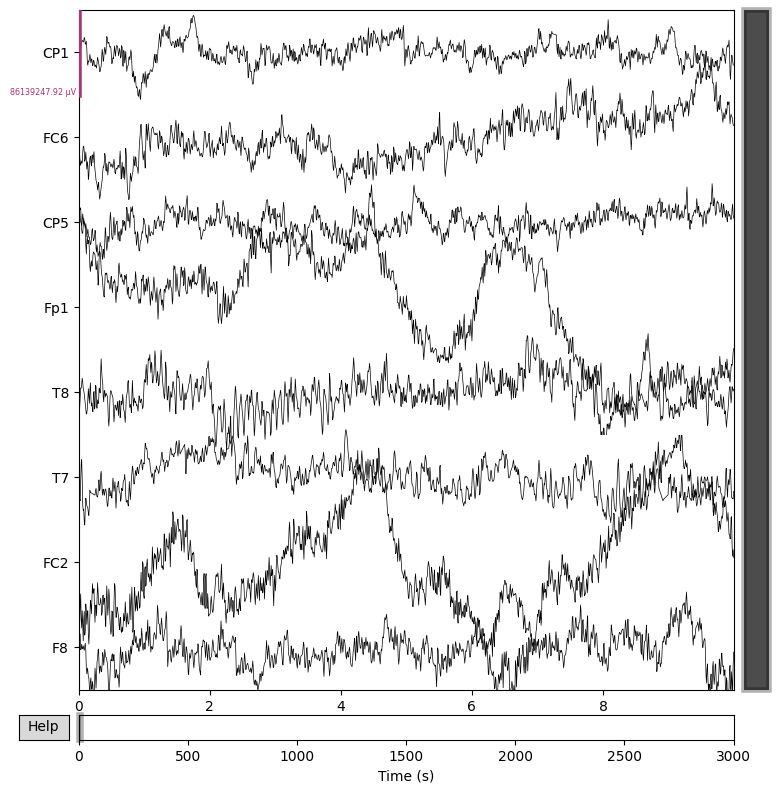

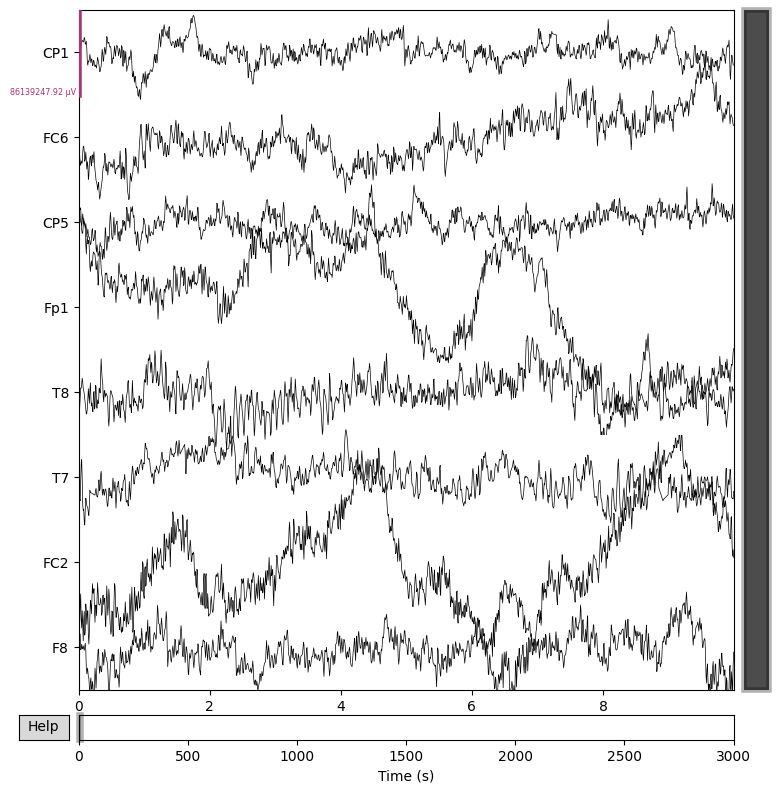

In [ ]:
n_trials, n_channels, n_samples_per_trial = Data.shape
visdata = Data.reshape(n_channels, n_trials * n_samples_per_trial)

ch_names = selected_channels
ch_types = ['eeg'] * n_channels
sfreq = v.SFREQ 

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# objek MNE RawArray dari data NumPy dan Info
mne_object = mne.io.RawArray(visdata, info)

# Plot sinyal menggunakan fungsi bawaan MNE
#    'n_channels' -> berapa channel yang ditampilkan sekaligus
#    'duration' -> berapa detik data yang ditampilkan per layar
#    'scalings' -> mengatur skala plot agar sinyal terlihat jelas
mne_object.plot(n_channels=8, duration=10, scalings='auto')

In [7]:
all_types_to_load = v.TRIAL_TYPES + v.BASELINE_TYPE

mne_objects_dict = {}

for data_type in all_types_to_load:
    temp_full_dataset = dataset.load_dataset(
        data_type = 'raw', test_type=data_type)
    temp_channels_selection = ga.get_subset(
        data=temp_full_dataset,
        all_genes=all_channels_list,
        subset_genes=selected_channels
    )

    n_trials, n_channels, n_samples = temp_channels_selection.shape
    data_for_mne = temp_channels_selection.reshape(
        n_channels, n_trials * n_samples)
    
    info = mne.create_info(
        ch_names=selected_channels,
        sfreq=v.SFREQ,
        ch_types=['eeg'] * len(selected_channels)
        )
    
    mne_objects_dict[data_type] = mne.io.RawArray(data_for_mne, info)

print(f'{len(mne_objects_dict)} jenis data telah dimuat ke dalam dictionary mne_objects_dict.')


    

Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
4 jenis data telah dimuat ke dalam dictionary mne_objects_dict.


## Decomposed Data & Differential Entropy


In [8]:
decomposed_data = features.decompose_to_bands(mne_objects_dict)

de_features = features.differential_entropy_features(decomposed_data)
if de_features:
    print(
        f"Task yang berhasil diekstrak fiturnya: {list(de_features.keys())}")
    first_key = list(de_features.keys())[0]
    print(
        f"Bentuk vektor fitur untuk '{first_key}': {de_features[first_key].shape}")

Task yang berhasil diekstrak fiturnya: ['Arithmetic', 'Mirror', 'Stroop']
Bentuk vektor fitur untuk 'Arithmetic': (32,)


Menampilkan visualisasi sinyal per band untuk task: Arithmetic

--- Visualisasi untuk Band: Theta ---


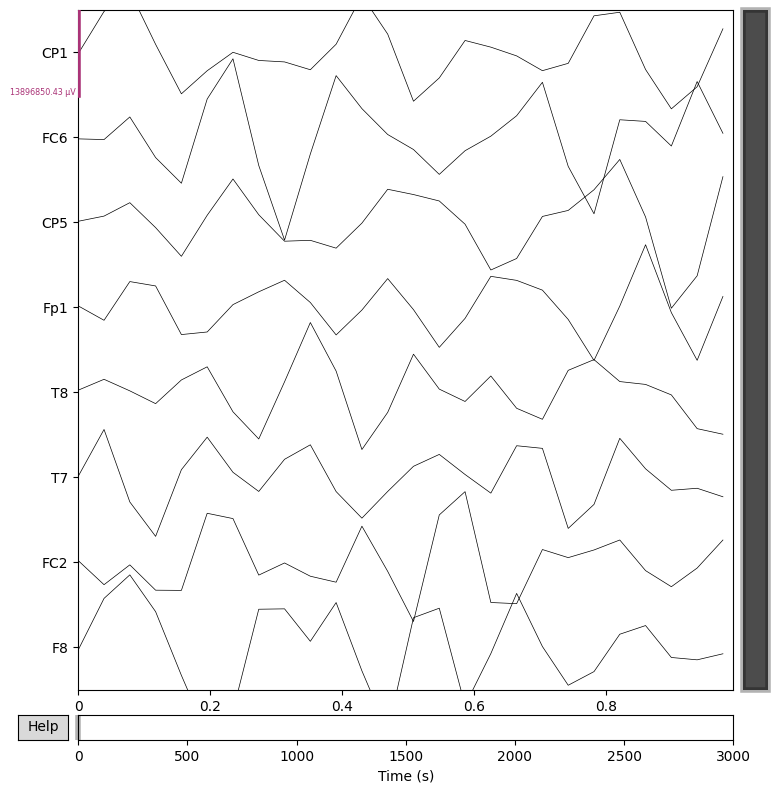


--- Visualisasi untuk Band: Alpha ---


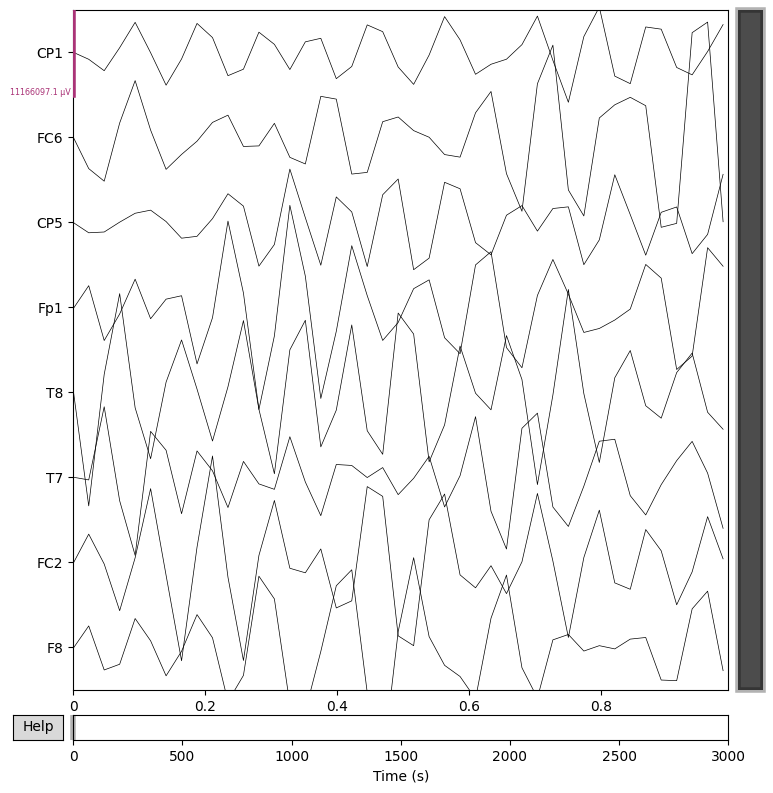


--- Visualisasi untuk Band: Beta ---


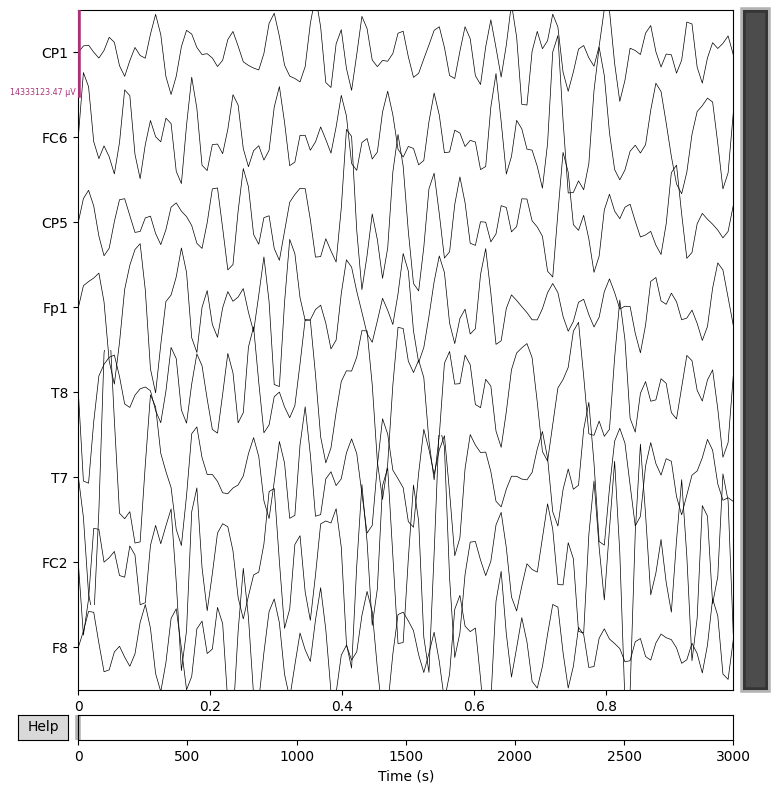


--- Visualisasi untuk Band: Gamma ---


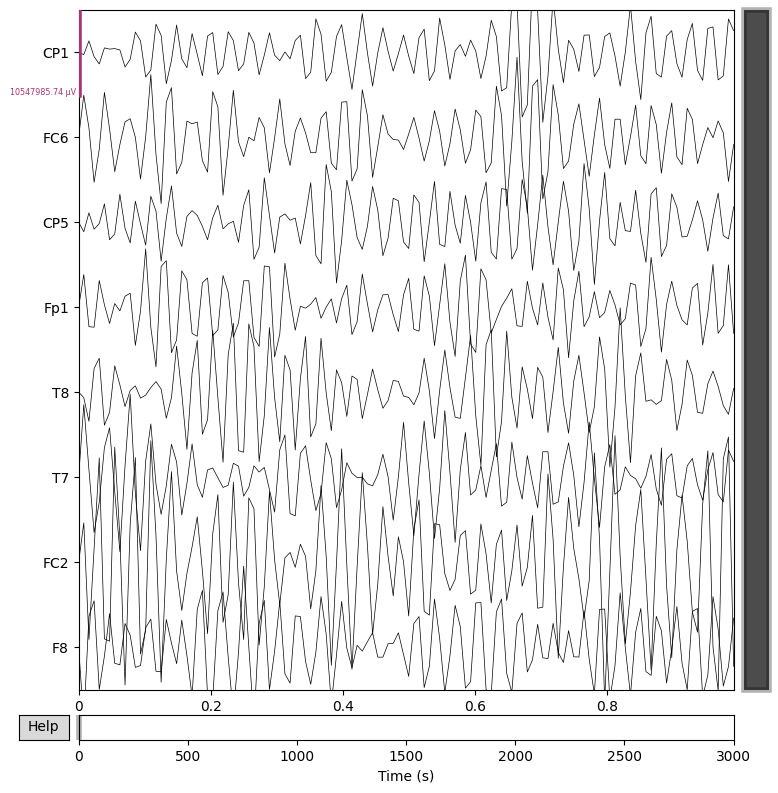

In [ ]:

task_to_visualize = 'Arithmetic'

band_order = ['Theta', 'Alpha', 'Beta', 'Gamma']

print(
    f"Menampilkan visualisasi sinyal per band untuk task: {task_to_visualize}")

# Loop untuk setiap nama band
for band_name in band_order:
    print(f"\n--- Visualisasi untuk Band: {band_name} ---")

    # Mengakses objek MNE untuk task dan band yang spesifik
    mne_band_object = decomposed_data[task_to_visualize][band_name]

    mne_band_object.plot(n_channels=8, duration=1, scalings='auto')

## 3D Cube

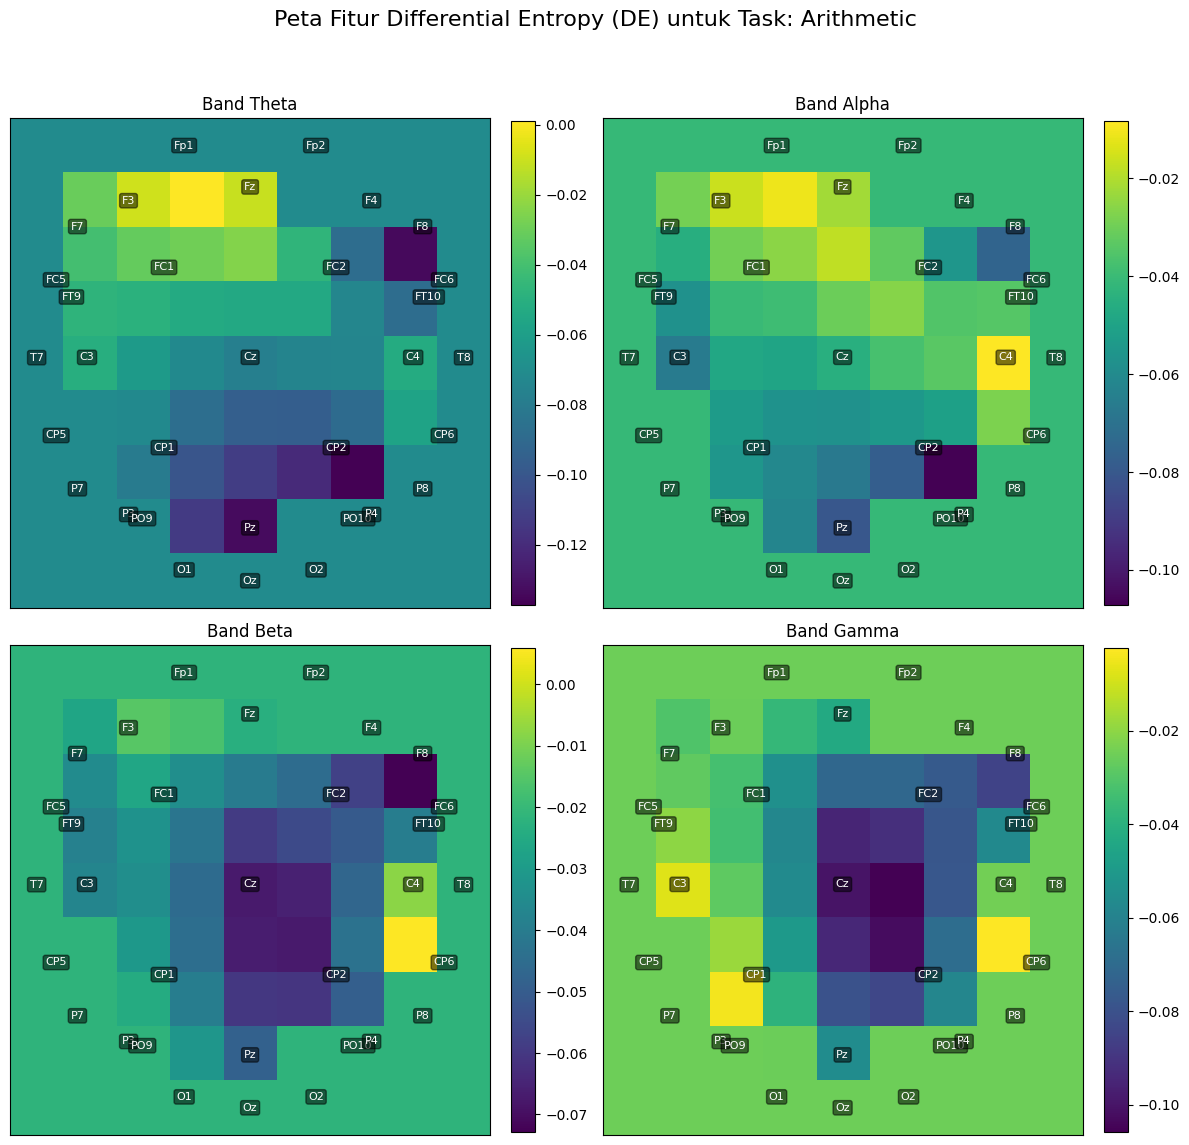

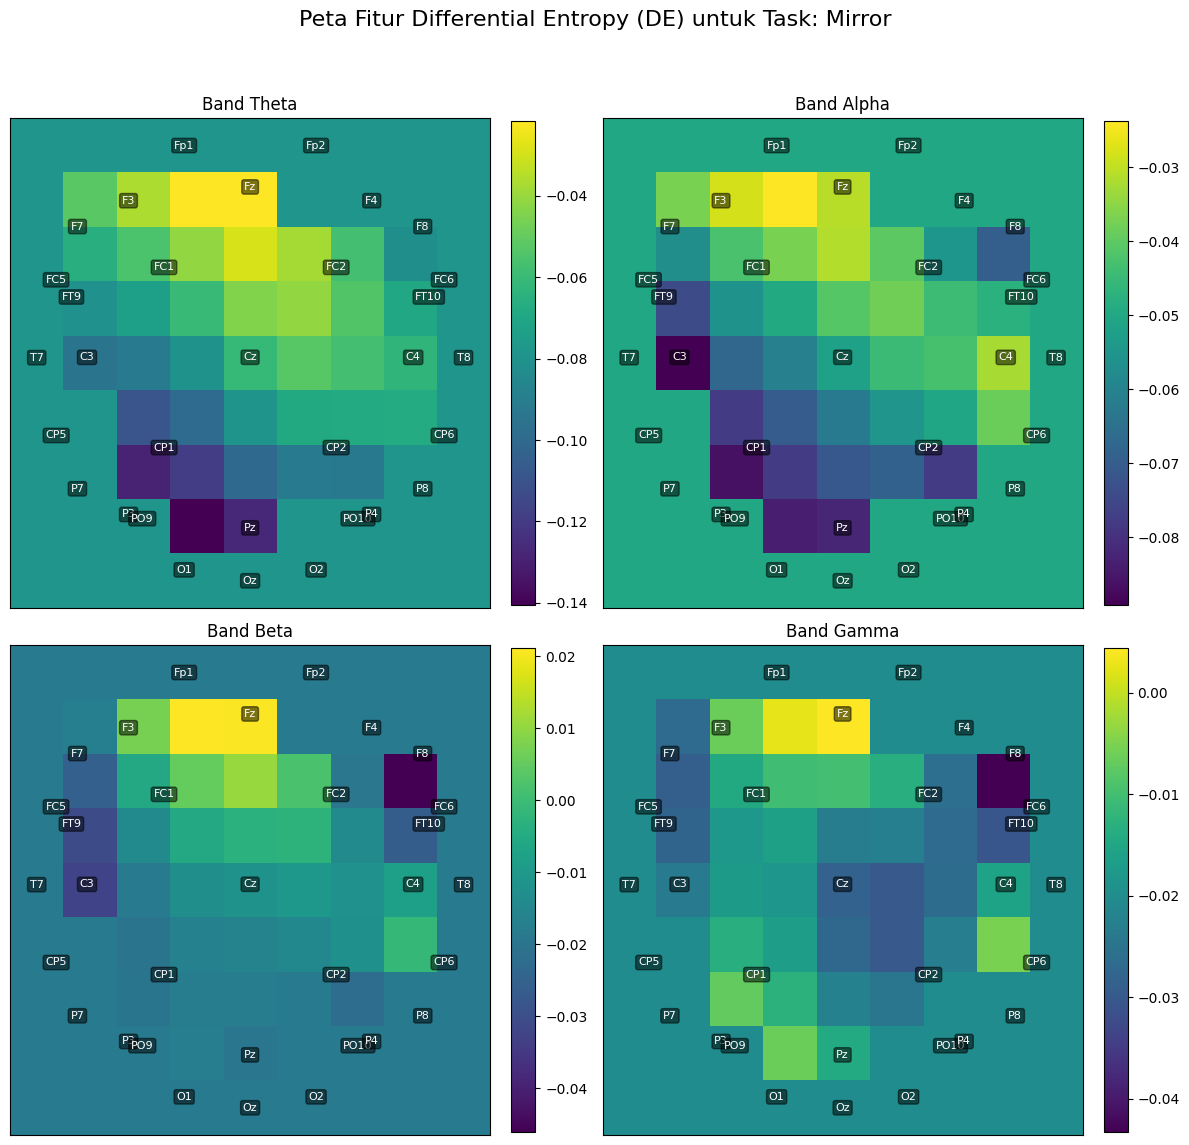

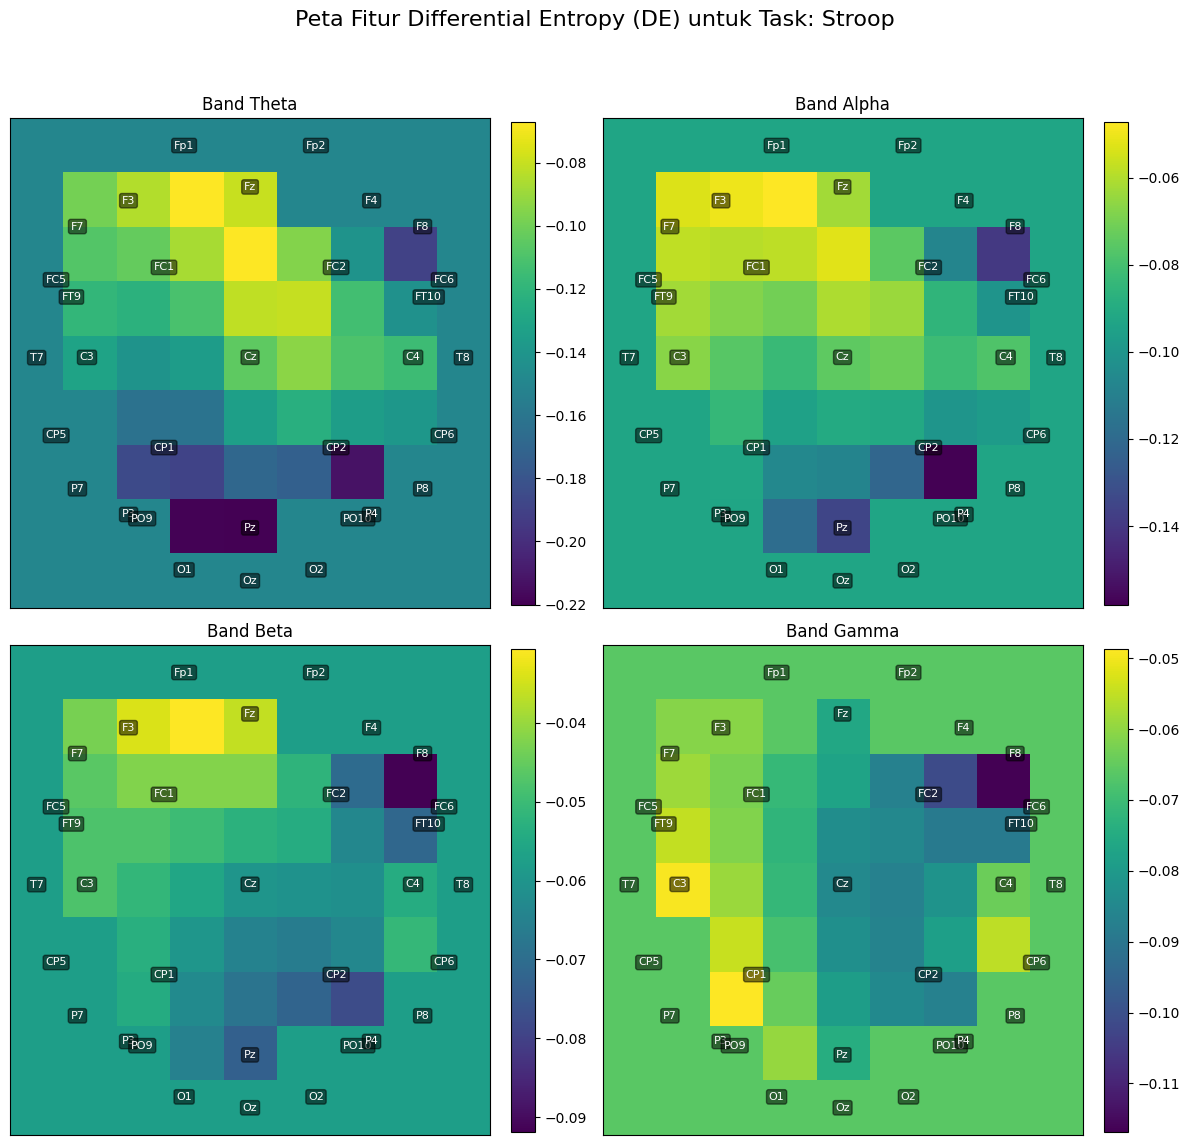

In [10]:
feature_maps_3d = features.create_3d_feature_maps(
    feature_vectors_dict=de_features,
    montage_path=v.CHANNELS_PATH,
    selected_channels_list=selected_channels
    )

for task_name, feature_map in feature_maps_3d.items():
    features.visualize_3d_feature_map(
        feature_map,
        montage_path=v.CHANNELS_PATH,
        title=f"Peta Fitur Differential Entropy (DE) untuk Task: {task_name}"
    )

## Classification

### CCN

In [ ]:
# Menggabungkan semua data task menjadi satu untuk diproses
all_task_data_list = []
for task_name in ["Arithmetic", "Mirror", "Stroop"]:
    temp_full_dataset = dataset.load_dataset(
        data_type="raw", test_type=task_name)
    temp_data_terseleksi = ga.get_subset(
        data=temp_full_dataset,
        all_genes=all_channels_list,
        subset_genes=selected_channels
    )
    all_task_data_list.append(temp_data_terseleksi)

# Menggabungkan data dari 3 task menjadi satu array besar (360, 8, 3200)
X_raw_selected = np.concatenate(all_task_data_list, axis=0)

# Mengubah data mentah menjadi epoch. Asumsi 2 detik per epoch.
# 3200 sampel / (128 Hz * 2 detik) = 12.5 -> 12 epoch per trial
epoched_data = dataset.convert_to_epochs(
    X_raw_selected, n_genes=len(selected_channels), sfreq=v.SFREQ)
# Bentuk output: (360 * 12, 8, 256)

# Ekstrak fitur Hjorth dari setiap epoch
X_features = features.hjorth_features(epoched_data)
# Bentuk output: (4320, 24) -> 4320 sampel, 24 fitur (8 channel * 3 fitur Hjorth)
print(f"Ekstraksi fitur selesai. Bentuk X: {X_features.shape}")


labels_df = dataset.load_labels()
# Mendapatkan label untuk semua 3 task dan ulangi untuk setiap epoch
num_epochs = epoched_data.shape[0] // X_raw_selected.shape[0]  # -> 12
y_binary = []
for task_name in ["Arithmetic", "Mirror", "Stroop"]:
    labels_for_task = dataset.format_labels(
        labels_df, test_type=task_name, epochs=num_epochs)
    y_binary.append(labels_for_task)

y_binary = np.concatenate(y_binary, axis=0)

# Ubah ke one-hot encoding
y = to_categorical(y_binary, num_classes=2)
print(f"Persiapan label selesai. Bentuk y: {y.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Bentuk X_train: {X_train.shape}, Bentuk y_train: {y_train.shape}")



input_size = X_train.shape[1]  # -> 24
output_size = y_train.shape[1]  # -> 2

model_nn = classifiers.NN(
    input_size=input_size, output_size=output_size,
    num_layers=3, num_neurons=[64, 32, 16], dropout_rate=0.3
)
model_nn.compile(optimizer='adam',
                 loss='categorical_crossentropy', metrics=['accuracy'])

print("\nMemulai pelatihan model NN...")
history = model_nn.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

print("\n--- Mengevaluasi Performa Model ---")
loss, accuracy = model_nn.evaluate(X_test, y_test, verbose=0)
print(f"Akurasi final pada data test: {accuracy:.2%}")



Ekstraksi fitur selesai. Bentuk X: (4320, 24)
Persiapan label selesai. Bentuk y: (4320, 2)
Bentuk X_train: (3456, 24), Bentuk y_train: (3456, 2)

Memulai pelatihan model NN...
Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5140 - loss: 22.8146 - val_accuracy: 0.6400 - val_loss: 11.0744
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5166 - loss: 7.0348 - val_accuracy: 0.4664 - val_loss: 5.0679
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5922 - loss: 3.2459 - val_accuracy: 0.6319 - val_loss: 3.0713
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5854 - loss: 3.6267 - val_accuracy: 0.6123 - val_loss: 2.5867
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5919 - loss: 2.5565 - val_accuracy: 0.6181 - val_loss: 2.7985
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6135 - loss: 1.6807 - val_accuracy: 0.5741 - val_loss: 2.1390
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


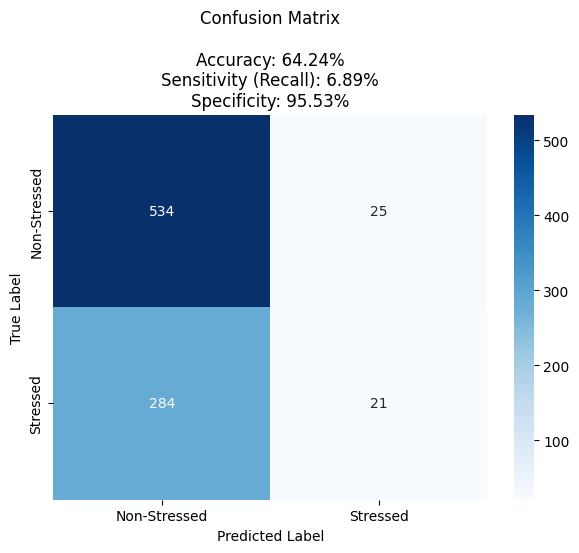


Laporan Klasifikasi Rinci:
              precision    recall  f1-score   support

Non-Stressed       0.65      0.96      0.78       559
    Stressed       0.46      0.07      0.12       305

    accuracy                           0.64       864
   macro avg       0.55      0.51      0.45       864
weighted avg       0.58      0.64      0.54       864



In [12]:
import metrics

y_pred_prob = model_nn.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
metrics.plot_conf_matrix_and_stats(conf_matrix, class_names=[
                                   'Non-Stressed', 'Stressed'])